In [ ]:
# INSTALL & IMPORTS
!pip install imread --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet
!pip install tensorflow --quiet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras import layers, models

from google.colab import drive

print("TensorFlow version:", tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 45.2 MB/s eta 0:00:00
TensorFlow version: 2.18.0


In [ ]:
# MOUNT DRIVE & DEFINE PATHS

drive.mount('/content/drive', force_remount=True)

dataset_path = "/content/drive/MyDrive/cassava_dataset"
image_dir    = os.path.join(dataset_path, "train_images")
csv_file     = os.path.join(dataset_path, "train.csv")

print("CSV exists:", os.path.exists(csv_file))
print("Image folder exists:", os.path.exists(image_dir))

Mounted at /content/drive
CSV exists: True
Image folder exists: True


In [ ]:
#LOAD & PREPARE DATAFRAME
train_df = pd.read_csv(csv_file)
train_df['label'] = train_df['label'].astype(str)

# Human-readable mapping for class names
disease_names = {
    "0": "CBB",    # Cassava Bacterial Blight
    "1": "CBSD",   # Cassava Brown Streak Disease
    "2": "CGM",    # Cassava Green Mottle
    "3": "CMD",    # Cassava Mosaic Disease
    "4": "Healthy"
}

print("Total samples:", len(train_df))
print(train_df.head())

Total samples: 21397
         image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1
3  1000723321.jpg     1
4  1000812911.jpg     3


In [ ]:
# Check for missing values
missing_values = train_df.isnull().sum()

# Print the count of missing values for each column
print("Missing values per column:")
print(missing_values)

Missing values per column:
image_id    0
label       0
dtype: int64


In [ ]:
#  STRATIFIED SPLIT INTO train_raw & val_df
train_raw, val_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df['label'],
    random_state=42
)

print("train_raw samples:", len(train_raw))
print("val_df samples:", len(val_df))

train_raw samples: 17117
val_df samples: 4280


Unbalanced class distribution (train_raw):
label
3    10526
4     2061
2     1909
1     1751
0      870
Name: count, dtype: int64


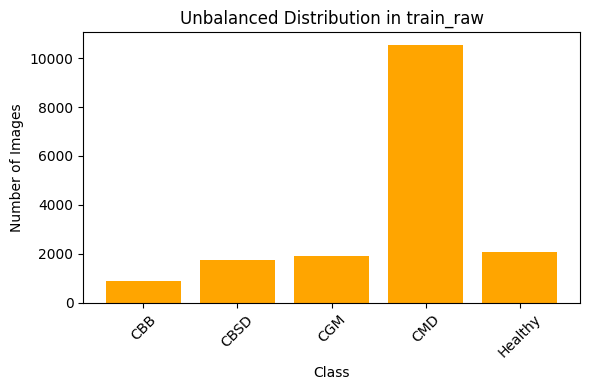

In [ ]:
#  PRINT & PLOT UNBALANCED train_raw
print("Unbalanced class distribution (train_raw):")
print(train_raw['label'].value_counts())

plt.figure(figsize=(6,4))
counts_raw = train_raw['label'].value_counts().sort_index() #calculate the count of each label again, but this time it sort by class index to ensure the order is consistent
labels_raw = [disease_names[lbl] for lbl in counts_raw.index] # replaces the numeric class labels with human-readable names
plt.bar(labels_raw, counts_raw.values, color='orange')
plt.title("Unbalanced Distribution in train_raw")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#  BALANCE train_raw BY OVERSAMPLING
class_counts = train_raw['label'].value_counts() # tells which classes have fewer samples and which have more
max_count = class_counts.max() # find the maximum number of samples among all the classes

balanced_dfs = []
# oversampling
for cls, cnt in class_counts.items():
    cls_df = train_raw[train_raw['label'] == cls]
    if cnt == max_count:
        balanced_dfs.append(cls_df)
    else:
        oversampled = cls_df.sample(max_count, replace=True, random_state=42)
        balanced_dfs.append(oversampled)

train_balanced = pd.concat(balanced_dfs).reset_index(drop=True)
train_balanced = train_balanced.sample(frac=1.0, random_state=42).reset_index(drop=True)


Balanced class distribution (train_balanced):
label
2    10526
1    10526
4    10526
3    10526
0    10526
Name: count, dtype: int64


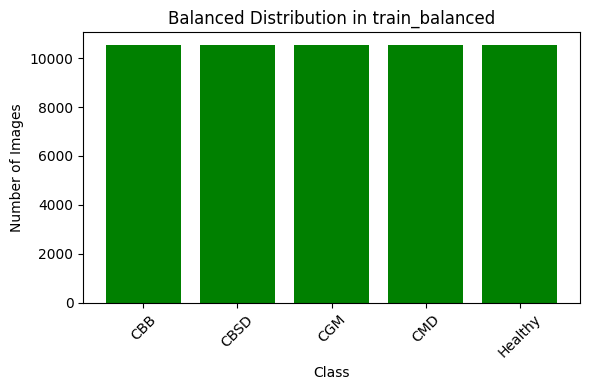

In [ ]:
#  PRINT & PLOT BALANCED train_balanced
print("\nBalanced class distribution (train_balanced):")
print(train_balanced['label'].value_counts())

plt.figure(figsize=(6,4))
counts_bal = train_balanced['label'].value_counts().sort_index()
labels_bal = [disease_names[lbl] for lbl in counts_bal.index]
plt.bar(labels_bal, counts_bal.values, color='green')
plt.title("Balanced Distribution in train_balanced")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

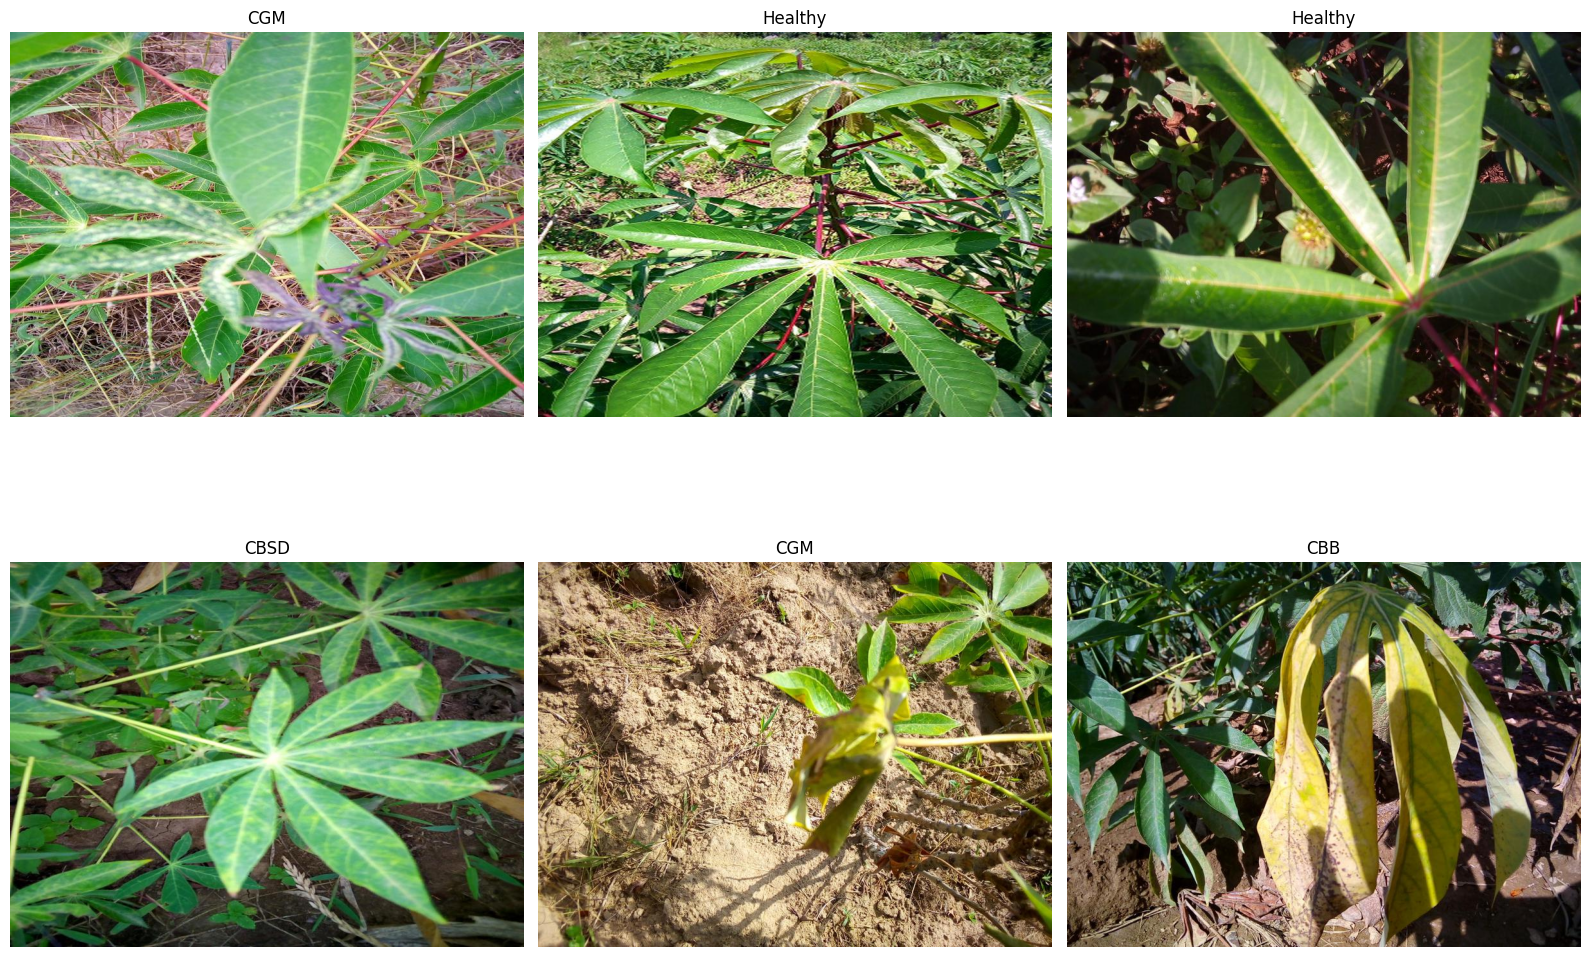

In [ ]:
#   VISUALIZING A FEW SAMPLES FROM train_balanced
plt.figure(figsize=(16, 12))
shown = 0 #counts how many images displayed so far.
i = 0  #index to loop through the dataframe.
while shown < 6 and i < len(train_balanced):
    img_path = os.path.join(image_dir, train_balanced.iloc[i]['image_id'])
    if os.path.exists(img_path):
        plt.subplot(2, 3, shown + 1)
        img = Image.open(img_path)
        plt.imshow(np.array(img))
        lbl = train_balanced.iloc[i]['label']
        plt.title(disease_names[lbl])
        plt.axis('off')
        shown += 1   # is increased only when a valid image is displayed
    i += 1   #is always incremented to move to the next row in the dataframe.
plt.tight_layout()
plt.show()

In [ ]:
#  CHECK IMAGE SIZES IN train_balanced
sizes = []
for i in range(0, len(train_balanced), 250):
    path = os.path.join(image_dir, train_balanced.iloc[i]['image_id'])
    if os.path.exists(path):
        img = Image.open(path)
        sizes.append(np.array(img).shape)
print("Unique image sizes (sample every 250th):", set(sizes))

Unique image sizes (sample every 250th): {(600, 800, 3)}


In [ ]:
#  CREATE IMAGE GENERATORS
IMG_W, IMG_H = 150, 150  # Model input dimensions

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalizes pixel values from 0–255 to a range of 0–1, which helps the model train better.
    rotation_range=40, #Randomly rotates images up to 40 degrees.
    zoom_range=0.2, #Random zoom in or out by 20%.
    width_shift_range=0.1, #Randomly shift the image horizontally or vertically by 10%.
    height_shift_range=0.1,
    shear_range=0.1, #Applies random shearing transformation.
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest' #Fills in new pixels that may be created during transformation using the nearest pixel value.
)

val_datagen = ImageDataGenerator(rescale=1./255)

#Load Augmented Training Data From DataFrame
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_balanced,
    directory=image_dir,
    x_col='image_id',
    y_col='label',
    target_size=(IMG_W, IMG_H),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)
#Load Validation Data Without Augmentation
val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='image_id',
    y_col='label',
    target_size=(IMG_W, IMG_H),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 43963 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8667 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 3596 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 684 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
#  BUILD A SINGLE CNN MODEL
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_W, IMG_H, 3)),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    # Block 2
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    # Flatten & Dense
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # 5 classes
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=Nadam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

# SET CALLBACKS
#early_stop = EarlyStopping(
 #   monitor='val_accuracy',
  #  patience=7,
   # restore_best_weights=True,
    #verbose=1
#)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

#  TRAIN THE MODEL
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    #callbacks=[early_stop, reduce_lr],
    callbacks=[ reduce_lr],
    verbose=1
)

# SAVE THE TRAINED MODEL
model.save('cassava_cnn_balanced.h5')
print("Model saved as cassava_cnn_balanced.h5")





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,037,125 (72.62 MB)

 Trainable params: 19,036,677 (72.62 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 4512s 7s/step - accuracy: 0.3061 - loss: 2.7591 - val_accuracy: 0.2542 - val_loss: 1.6435 - learning_rate: 0.0010
Epoch 2/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 525s 744ms/step - accuracy: 0.4196 - loss: 1.3557 - val_accuracy: 0.2987 - val_loss: 1.6606 - learning_rate: 0.0010
Epoch 3/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 515s 750ms/step - accuracy: 0.4784 - loss: 1.2701 - val_accuracy: 0.5506 - val_loss: 1.1292 - learning_rate: 0.0010
Epoch 4/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 514s 749ms/step - accuracy: 0.5082 - loss: 1.2151 - val_accuracy: 0.5706 - val_loss: 1.0660 - learning_rate: 0.0010
Epoch 5/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 511s 743ms/step - accuracy: 0.5331 - loss: 1.1705 - val_accuracy: 0.6129 - val_loss: 1.0728 - learning_rate: 0.0010
Epoch 6/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 522s 760ms/step - accuracy: 0.5524 - loss: 1.1294 - val_accuracy: 0.7013 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 7/30
687/687 ━━━━━━━━━━━━━━━━━━━━ 556s 752ms/step - accuracy

Model saved as cassava_cnn_balanced.h5


In [ ]:
#  PRINT FINAL VALIDATION ACCURACY ==========
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"\nFinal Validation Accuracy after training: {final_val_accuracy * 100:.2f}%")


Final Validation Accuracy after training: 76.59%


In [ ]:
# ========== PRINT FINAL TRAINING ACCURACY ==========
final_train_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")


Final Training Accuracy: 73.72%


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_path = '/content/drive/MyDrive/cassava_cnn_balanced.h5'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
model.save(save_path)
print(f"Model saved to Google Drive at: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive at: /content/drive/MyDrive/cassava_cnn_balanced.h5


In [ ]:
/content/drive/MyDrive/cassava_dataset/train_images/1595141360.jpg

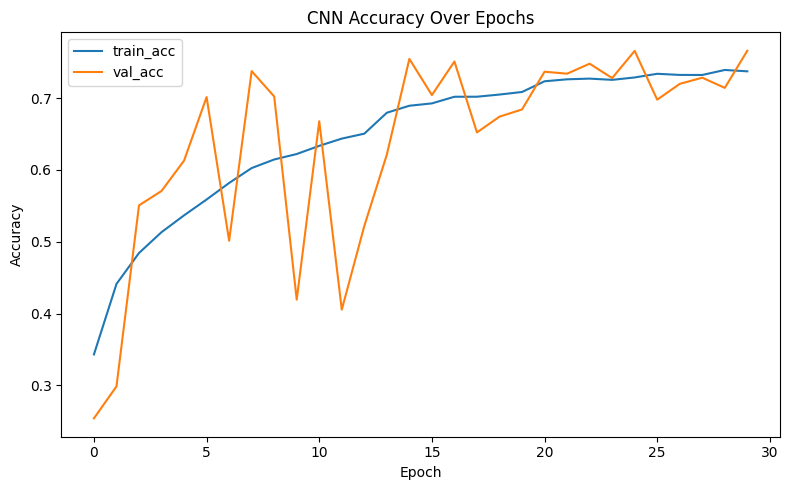

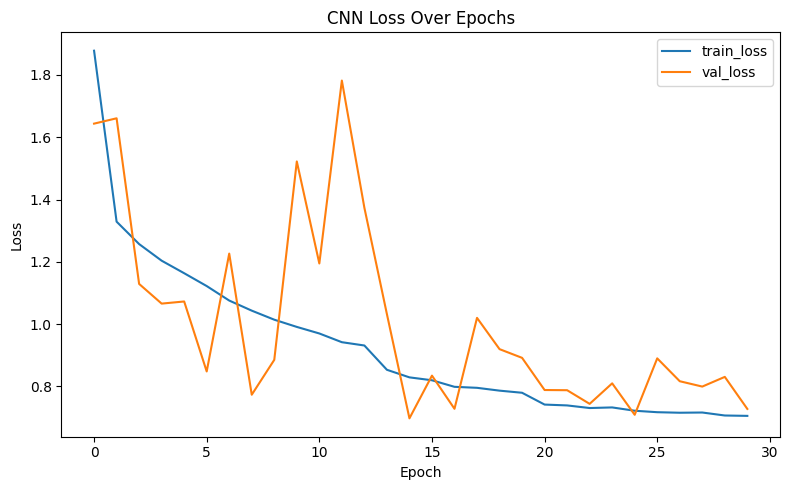

In [ ]:
# ========== PLOT TRAINING & VALIDATION ACCURACY / LOSS ==========
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("CNN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("CNN Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

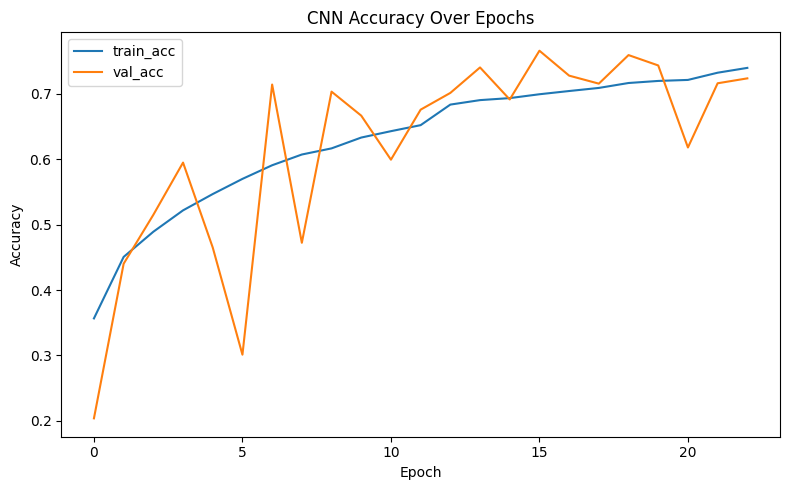

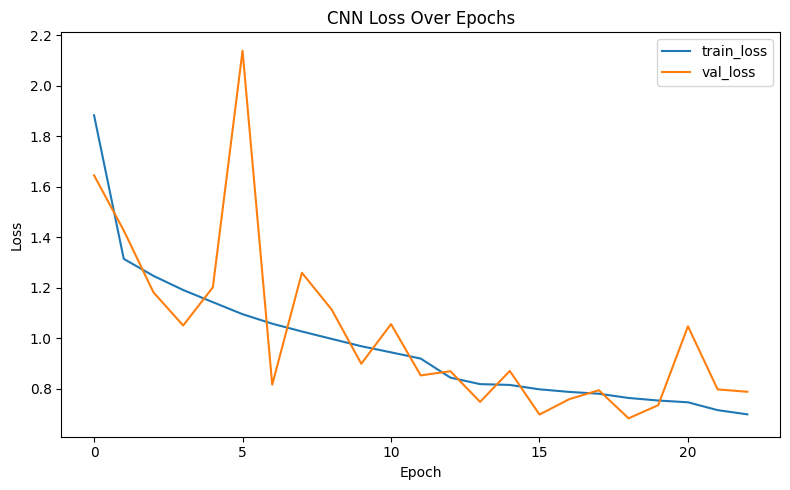

In [ ]:
# ========== PLOT TRAINING & VALIDATION ACCURACY / LOSS ==========
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("CNN Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("CNN Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ========== PREDICT ON VALIDATION SET ==========
val_gen.reset()
pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_gen.labels

# ========== CLASSIFICATION REPORT (Precision, Recall, F1) ==========
inv_class_map = {v: k for k, v in val_gen.class_indices.items()}
class_labels = [inv_class_map[i] for i in range(len(inv_class_map))]
human_labels = [disease_names[label_str] for label_str in class_labels]

print("Classification Report on Validation Set:\n")
print(
    classification_report(
        y_true,
        y_pred,
        labels=list(range(len(class_labels))),
        target_names=human_labels,
        digits=4
    )
)


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step
Classification Report on Validation Set:

              precision    recall  f1-score   support

         CBB     0.5469    0.3684    0.4403       190
        CBSD     0.6550    0.6137    0.6337       365
         CGM     0.5496    0.7094    0.6194       406
         CMD     0.9523    0.8442    0.8950      2201
     Healthy     0.4823    0.7235    0.5788       434

    accuracy                         0.7659      3596
   macro avg     0.6372    0.6518    0.6334      3596
weighted avg     0.7985    0.7659    0.7752      3596



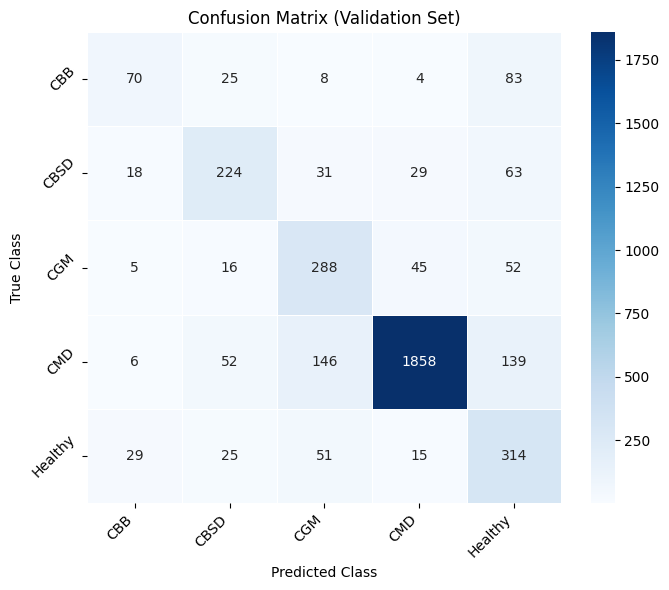

In [ ]:
# ========== CONFUSION MATRIX HEATMAP ==========
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_labels))))

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=human_labels,
    yticklabels=human_labels,
    linewidths=0.5
)
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Confusion Matrix (Validation Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#normaalizing the confusion matrix for better graph

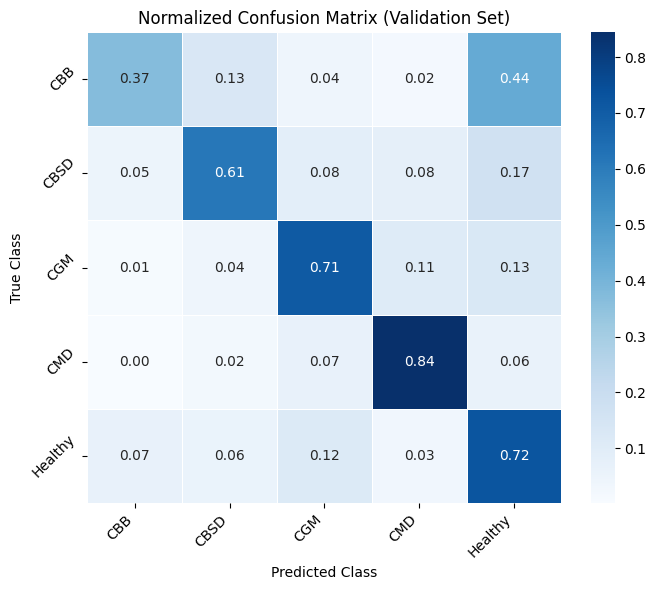

In [ ]:
# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(7,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f", # Use .2f for floating point numbers with 2 decimal places
    cmap="Blues",
    xticklabels=human_labels,
    yticklabels=human_labels,
    linewidths=0.5
)
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# example paths
/content/drive/MyDrive/cassava_dataset/train_images/1576606254.jpg
/content/drive/MyDrive/cassava_dataset/train_images/1579761476.jpg
/content/drive/MyDrive/cassava_dataset/train_images/1595577438.jpg
/content/drive/MyDrive/cassava_dataset/train_images/1593622565.jpg
/content/drive/MyDrive/cassava_dataset/train_images/1595096662.jpg

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model loaded successfully from: /content/drive/MyDrive/cassava_cnn_balanced.h5

Cassava Leaf Disease Classifier
-------------------------------

Options:
1. Predict from an image file
2. Exit
Enter your choice (1 or 2): 1

Enter the full path to the image file: /content/drive/MyDrive/cassava_dataset/train_images/1595577438.jpg


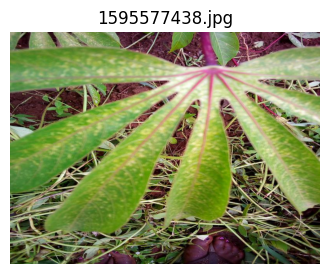

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

=== Prediction Results ===
Predicted disease: CGM (Class 2)
Confidence: 99.81%

Detailed probabilities:
  CBB            : 0.00%
  CBSD           : 0.00%
  CGM            : 99.81%
  CMD            : 0.00%
  Healthy        : 0.19%

Options:
1. Predict from an image file
2. Exit
Enter your choice (1 or 2): 2
Exiting program.


In [ ]:
# User Interface for Cassava Disease Prediction
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from google.colab import drive

# Mount Google Drive (only needed in Colab)
drive.mount('/content/drive')

# Disease classification mapping
disease_names = {
    0: "CBB",    # Cassava Bacterial Blight
    1: "CBSD",   # Cassava Brown Streak Disease
    2: "CGM",    # Cassava Green Mottle
    3: "CMD",    # Cassava Mosaic Disease
    4: "Healthy"
}

# Model configuration
IMG_W, IMG_H = 150, 150
# Update this path to where you saved your model in Google Drive
model_path = "/content/drive/MyDrive/cassava_cnn_balanced.h5"

class CassavaDiseasePredictor:
    def __init__(self):
        """Initialize the predictor by loading the trained model"""
        try:
            self.model = load_model(model_path)
            print(f"Model loaded successfully from: {model_path}")
        except Exception as e:
            print(f"Error loading model: {e}")
            raise

    def preprocess_image(self, image_path):
        """Load and preprocess an image for prediction"""
        try:
            img = Image.open(image_path).convert("RGB")
            img_resized = img.resize((IMG_W, IMG_H))
            x = np.array(img_resized, dtype=np.float32) / 255.0
            x = np.expand_dims(x, axis=0)  # Add batch dimension
            return x, img
        except Exception as e:
            print(f"Error processing image: {e}")
            return None, None

    def predict(self, image_path, show_image=True):
        """Make a prediction on a single image"""
        # Preprocess the image
        x, img = self.preprocess_image(image_path)
        if x is None:
            return None

        # Display the image if requested
        if show_image:
            plt.figure(figsize=(4,4))
            plt.imshow(np.array(img))
            plt.axis("off")
            plt.title(os.path.basename(image_path))
            plt.show()

        # Make prediction
        preds = self.model.predict(x)
        probs = preds[0]

        # Get top prediction
        top_index = np.argmax(probs)
        top_confidence = probs[top_index]

        # Prepare results
        results = {
            "top_class": disease_names[top_index],
            "class_number": int(top_index),
            "top_confidence": float(top_confidence),
            "all_probs": {disease_names[i]: float(p) for i, p in enumerate(probs)},
            "image": np.array(img)
        }

        return results

    def print_prediction_results(self, results):
        """Print the prediction results in a readable format"""
        if not results:
            print("No prediction results to display.")
            return

        print("\n=== Prediction Results ===")
        print(f"Predicted disease: {results['top_class']} (Class {results['class_number']})")
        print(f"Confidence: {results['top_confidence']:.2%}")
        print("\nDetailed probabilities:")
        for disease, prob in results['all_probs'].items():
            print(f"  {disease:<15}: {prob:.2%}")
        print("="*30)

def main():
    # Initialize the predictor
    try:
        predictor = CassavaDiseasePredictor()
    except:
        print("Failed to initialize predictor. Exiting.")
        return

    # Simple user interface
    print("\nCassava Leaf Disease Classifier")
    print("-------------------------------")

    while True:
        print("\nOptions:")
        print("1. Predict from an image file")
        print("2. Exit")

        choice = input("Enter your choice (1 or 2): ").strip()

        if choice == "1":
            # Get image path from user
            image_path = input("\nEnter the full path to the image file: ").strip()

            # Verify the file exists
            if not os.path.exists(image_path):
                print(f"Error: File not found at '{image_path}'")
                continue

            # Make and display prediction
            try:
                results = predictor.predict(image_path)
                if results:
                    predictor.print_prediction_results(results)
            except Exception as e:
                print(f"Error during prediction: {e}")

        elif choice == "2":
            print("Exiting program.")
            break

        else:
            print("Invalid choice. Please enter 1 or 2.")

if __name__ == "__main__":
    main()


In [ ]:
#EfficientNet

In [ ]:
# ========== INSTALL & IMPORTS ==========
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00


In [ ]:
# ========== CONFIG & MOUNT ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

drive.mount('/content/drive', force_remount=True)
BASE = "/content/drive/MyDrive/cassava_dataset"
CSV  = os.path.join(BASE, "train.csv")
IMGDIR = os.path.join(BASE, "train_images")

assert os.path.exists(CSV), f"{CSV} not found!"
assert os.path.exists(IMGDIR), f"{IMGDIR} not found!"

# ========== LOAD & SPLIT DATA ==========
df = pd.read_csv(CSV)
df['label'] = df['label'].astype(int)

# Stratified split: 80% train_raw, 20% val_df
train_raw, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)

Using device: cuda
Mounted at /content/drive


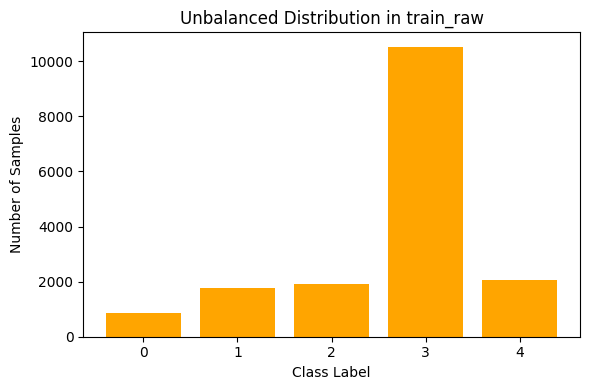

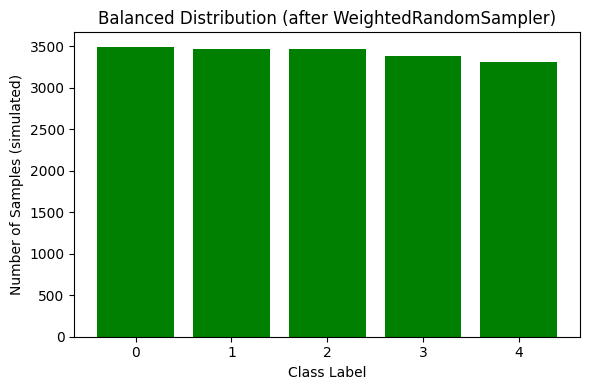

In [ ]:
# ========== PLOT UNBALANCED DISTRIBUTION ==========
counts_raw = train_raw['label'].value_counts().sort_index()
labels = [str(i) for i in counts_raw.index]
plt.figure(figsize=(6,4))
plt.bar(labels, counts_raw.values, color='orange')
plt.title("Unbalanced Distribution in train_raw")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

# ========== PREPARE WEIGHTS FOR SAMPLING ==========
# Inverse frequency: weight = 1 / count
class_counts = train_raw['label'].value_counts().sort_index().to_dict()
class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_raw['label']]

# ========== PLOT DISTRIBUTION AFTER SAMPLING (SIMULATED) ==========
sampler_for_plot = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)
# sample indices for one epoch
idxs = list(iter(sampler_for_plot))
# map to labels
train_raw_reset = train_raw.reset_index(drop=True)
sampled_counts = train_raw_reset.iloc[idxs]['label'].value_counts().sort_index()

labels = [str(i) for i in sampled_counts.index]
plt.figure(figsize=(6,4))
plt.bar(labels, sampled_counts.values, color='green')
plt.title("Balanced Distribution (after WeightedRandomSampler)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples (simulated)")
plt.tight_layout()
plt.show()


In [ ]:
# ========== DEFINE TRANSFORMS & DATASET ==========
IMG_SIZE = 150

train_tf = T.Compose([
    T.RandomRotation(30),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.tf = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_dir, row.image_id)).convert("RGB")
        return self.tf(img), row.label

# Before creating the dataset, filter train_raw to ensure all images exist
# This can be time-consuming for large datasets, consider adding a progress bar
print("Checking for missing training images...")
initial_train_count = len(train_raw)
train_raw_filtered = train_raw[train_raw['image_id'].apply(lambda x: os.path.exists(os.path.join(IMGDIR, x)))].copy()
missing_train_count = initial_train_count - len(train_raw_filtered)
if missing_train_count > 0:
    print(f"Warning: Removed {missing_train_count} rows from train_raw due to missing image files.")

# Re-calculate sample weights based on the filtered data
class_counts_filtered = train_raw_filtered['label'].value_counts().sort_index().to_dict()
# Handle cases where a class might be completely removed (unlikely with stratified split but good practice)
class_weights_filtered = {cls: 1.0/count if count > 0 else 0.0 for cls, count in class_counts_filtered.items()}
sample_weights_filtered = [class_weights_filtered[label] for label in train_raw_filtered['label']]


print("Checking for missing validation images...")
initial_val_count = len(val_df)
val_df_filtered = val_df[val_df['image_id'].apply(lambda x: os.path.exists(os.path.join(IMGDIR, x)))].copy()
missing_val_count = initial_val_count - len(val_df_filtered)
if missing_val_count > 0:
    print(f"Warning: Removed {missing_val_count} rows from val_df due to missing image files.")


train_ds = CassavaDataset(train_raw_filtered, IMGDIR, train_tf)
val_ds   = CassavaDataset(val_df_filtered,   IMGDIR, val_tf)


Checking for missing training images...
Checking for missing validation images...


In [ ]:
# ========== SAMPLER & DATALOADERS ==========
# Use the filtered sample weights
sampler = WeightedRandomSampler(
    weights=sample_weights_filtered,
    num_samples=len(sample_weights_filtered), # Number of samples should match the filtered dataset size
    replacement=True
)
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler, num_workers=2)
# Validation loader does not use sampler, but should use the filtered dataset
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,   num_workers=2)

# The rest of the code remains the same
# ========== BUILD & COMPILE EFFICIENTNETB0 ==========
model = models.efficientnet_b0(pretrained=True)
in_f = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_f, 5)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 78.1MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_l

In [ ]:
# ========== TRAINING LOOP ==========
best_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, 21):
    # Training
    model.train()
    running_loss = 0.0
    # The DataLoader now uses the filtered dataset, so no FileNotFoundError should occur
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        # running_loss += loss.item() * X.size(0) # This is incorrect for loss calculation over epochs
        running_loss += loss.item()
    # train_loss = running_loss / len(train_loader.dataset) # This is incorrect
    train_loss = running_loss / len(train_loader) # Calculate average loss per batch
    history['train_loss'].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            # val_loss += loss.item() * X.size(0) # This is incorrect
            val_loss += loss.item() # Calculate sum of batch losses
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())
    # val_loss /= len(val_loader.dataset) # This is incorrect
    val_loss /= len(val_loader) # Calculate average loss per batch
    val_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_pytorch.pth")
        print("↳ Saved new best model")

print("Best Validation Accuracy:", best_acc)


Epoch 01 | train_loss=0.1744 | val_loss=0.7879 | val_acc=0.8067
↳ Saved new best model
Epoch 02 | train_loss=0.1672 | val_loss=0.7875 | val_acc=0.8181
↳ Saved new best model
Epoch 03 | train_loss=0.1220 | val_loss=0.7998 | val_acc=0.8198
↳ Saved new best model
Epoch 04 | train_loss=0.1179 | val_loss=0.7957 | val_acc=0.8198
Epoch 05 | train_loss=0.1055 | val_loss=0.8329 | val_acc=0.8195
Epoch 06 | train_loss=0.0876 | val_loss=0.8624 | val_acc=0.8229
↳ Saved new best model
Epoch 07 | train_loss=0.0915 | val_loss=0.8529 | val_acc=0.8276
↳ Saved new best model
Epoch 08 | train_loss=0.0879 | val_loss=0.8702 | val_acc=0.8184
Epoch 09 | train_loss=0.0826 | val_loss=0.8504 | val_acc=0.8281
↳ Saved new best model
Epoch 10 | train_loss=0.0807 | val_loss=0.8504 | val_acc=0.8276
Epoch 11 | train_loss=0.0732 | val_loss=0.8735 | val_acc=0.8201
Epoch 12 | train_loss=0.0775 | val_loss=0.8738 | val_acc=0.8223
Epoch 13 | train_loss=0.0783 | val_loss=0.8684 | val_acc=0.8234
Epoch 14 | train_loss=0.0721 |

In [ ]:
from google.colab import drive
import os
import torch # Ensure torch is imported

# Mount Google Drive
drive.mount('/content/drive')

# Define save path in Google Drive
save_path = '/content/drive/MyDrive/best_efficientnet_pytorch.pth'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model
# Pass the model object as the first argument
torch.save(model.state_dict(), save_path)
print(f"Model saved to Google Drive at: {save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive at: /content/drive/MyDrive/best_efficientnet_pytorch.pth


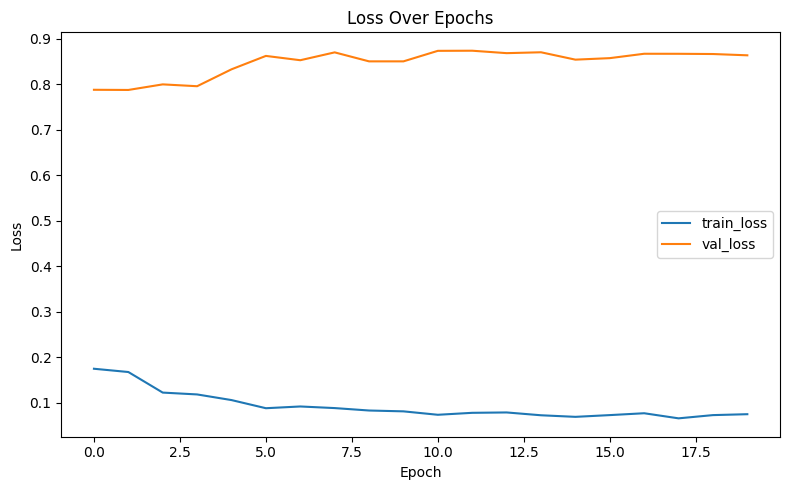

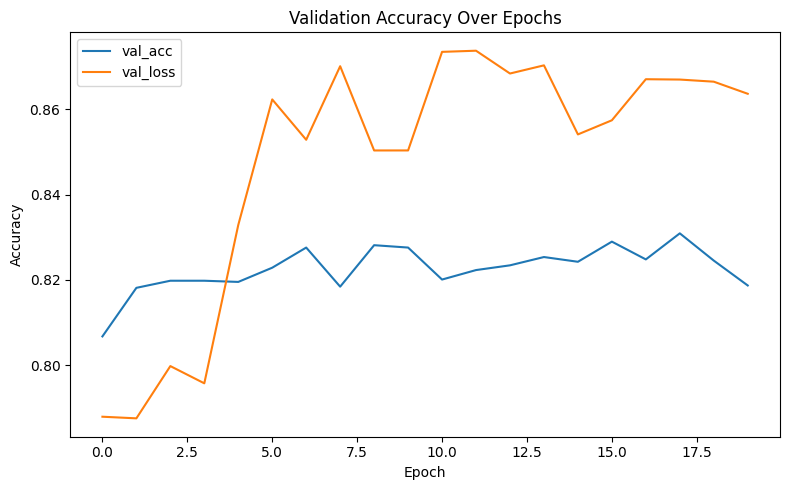

In [ ]:
# ========== PLOT TRAINING METRICS ==========
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['val_loss'], label='val_loss')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.tight_layout(); plt.show()


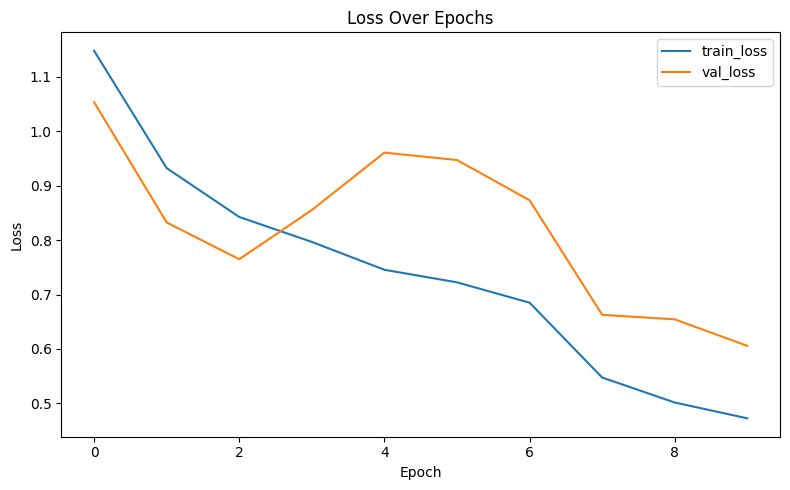

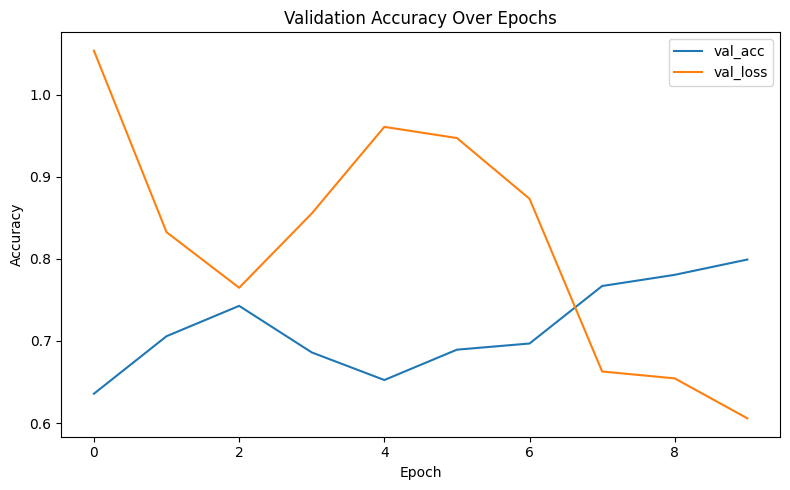

In [ ]:
# ========== PLOT TRAINING METRICS ==========
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['val_loss'], label='val_loss')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.tight_layout(); plt.show()



Classification Report:
               precision    recall  f1-score   support

         CBB     0.5160    0.6789    0.5864       190
        CBSD     0.7464    0.7096    0.7275       365
         CGM     0.5142    0.8005    0.6262       406
         CMD     0.9585    0.8701    0.9121      2201
     Healthy     0.6667    0.5668    0.6127       434

    accuracy                         0.7992      3596
   macro avg     0.6804    0.7252    0.6930      3596
weighted avg     0.8282    0.7992    0.8078      3596



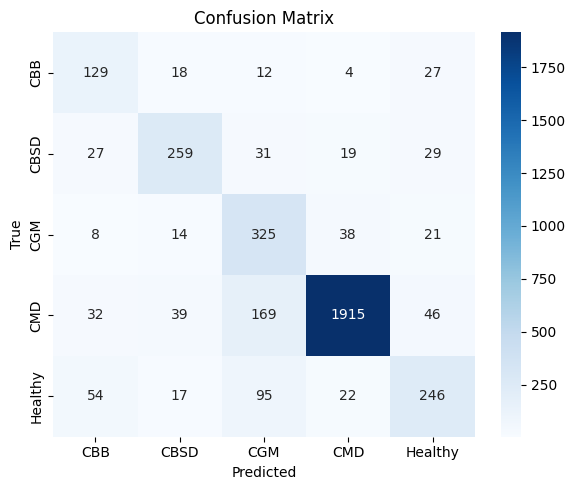

In [ ]:
# ========== EVALUATION & METRICS ==========
# Load best model weights
# Load the ResNet50 weights instead of the EfficientNetB0 weights
model.load_state_dict(torch.load("best_resnet50_pytorch.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        out = model(X)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        # Ensure y is on CPU before converting to numpy
        all_labels.extend(y.cpu().numpy())

label_map = {0:"CBB",1:"CBSD",2:"CGM",3:"CMD",4:"Healthy"}
print("\nClassification Report:\n",
      classification_report(all_labels, all_preds,
                            target_names=list(label_map.values()), digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()


Classification Report:
               precision    recall  f1-score   support

         CBB     0.5160    0.6789    0.5864       190
        CBSD     0.7464    0.7096    0.7275       365
         CGM     0.5142    0.8005    0.6262       406
         CMD     0.9585    0.8701    0.9121      2201
     Healthy     0.6667    0.5668    0.6127       434

    accuracy                         0.7992      3596
   macro avg     0.6804    0.7252    0.6930      3596
weighted avg     0.8282    0.7992    0.8078      3596



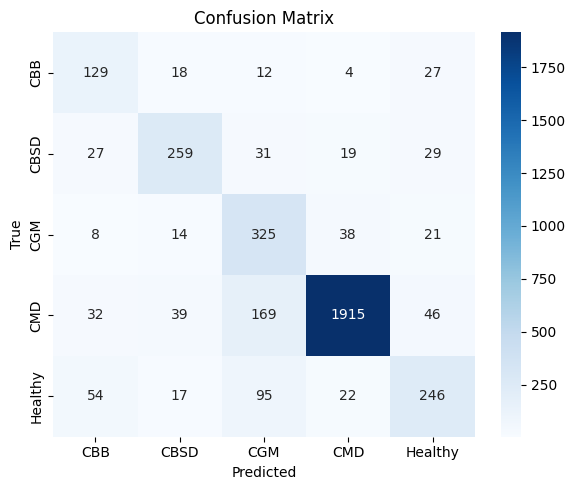

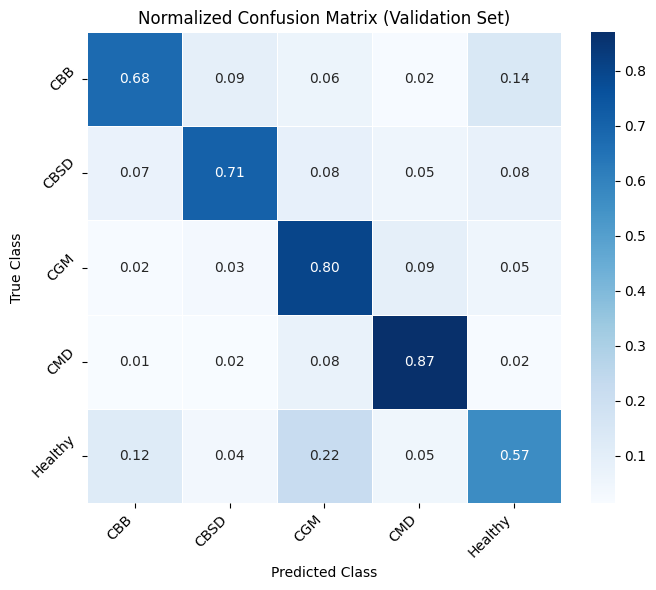

In [ ]:
# ========== EVALUATION & METRICS ==========
# Load best model weights
# Load the ResNet50 weights instead of the EfficientNetB0 weights
model.load_state_dict(torch.load("best_resnet50_pytorch.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    # Use the filtered validation loader
    for X, y in val_loader:
        X = X.to(device)
        out = model(X)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        # y is already a tensor, no need for .numpy() here
        all_labels.extend(y.cpu().numpy()) # Use .cpu().numpy() to be consistent

label_map = {0:"CBB",1:"CBSD",2:"CGM",3:"CMD",4:"Healthy"}

print("\nClassification Report:\n",
      classification_report(all_labels, all_preds,
                            target_names=list(label_map.values()), digits=4))

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the non-normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()

# Normalize the confusion matrix
# Divide each row by the sum of the row to get percentages within each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f", # Use .2f for floating point numbers with 2 decimal places
    cmap="Blues",
    xticklabels=list(label_map.values()), # Use labels from the label_map
    yticklabels=list(label_map.values()), # Use labels from the label_map
    linewidths=0.5
)
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#ResNet

In [ ]:
# ========== INSTALL & IMPORTS ==========
!pip install torch torchvision torchaudio --quiet
!pip install scikit-learn seaborn --quiet

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

In [ ]:
# ========== CONFIG & MOUNT ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

drive.mount('/content/drive', force_remount=True)
BASE   = "/content/drive/MyDrive/cassava_dataset"
CSV    = os.path.join(BASE, "train.csv")
IMGDIR = os.path.join(BASE, "train_images")

assert os.path.exists(CSV), f"{CSV} not found!"
assert os.path.exists(IMGDIR), f"{IMGDIR} not found!"

Using device: cuda
Mounted at /content/drive


In [ ]:
# ========== LOAD & SPLIT DATA ==========
df = pd.read_csv(CSV)
df['label'] = df['label'].astype(int)

# Stratified split: 80% train_raw, 20% val_df
train_raw, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)


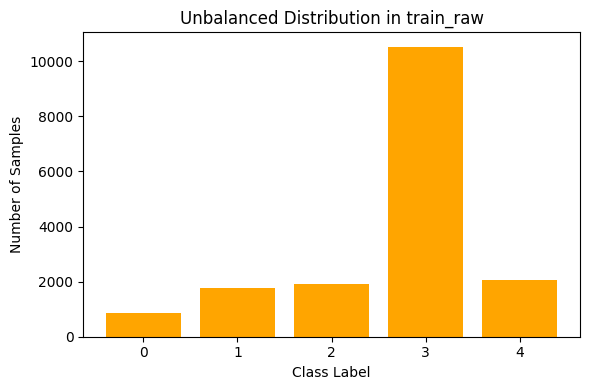

In [ ]:
# ========== PLOT UNBALANCED DISTRIBUTION ==========
counts_raw = train_raw['label'].value_counts().sort_index()
labels     = [str(i) for i in counts_raw.index]
plt.figure(figsize=(6,4))
plt.bar(labels, counts_raw.values, color='orange')
plt.title("Unbalanced Distribution in train_raw")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

In [ ]:
# ========== PREPARE WEIGHTS FOR SAMPLING ==========
class_counts   = train_raw['label'].value_counts().sort_index().to_dict()
class_weights  = {cls: 1.0/count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for label in train_raw['label']]
sampler        = WeightedRandomSampler(weights=sample_weights,
                                       num_samples=len(sample_weights),
                                       replacement=True)

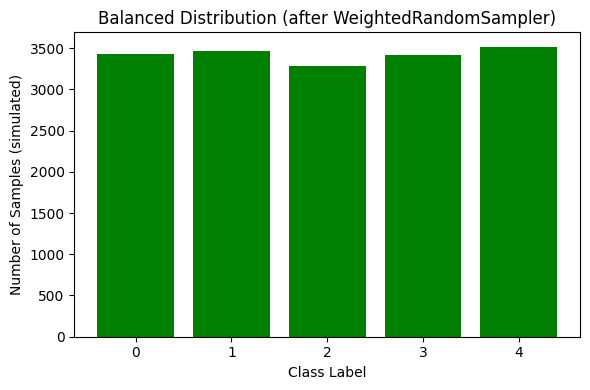

In [ ]:
# ========== PLOT DISTRIBUTION AFTER SAMPLING (SIMULATED) ==========
idxs         = list(iter(sampler))
train_reset  = train_raw.reset_index(drop=True)
sampled_cnts = train_reset.iloc[idxs]['label'].value_counts().sort_index()

labels_s = [str(i) for i in sampled_cnts.index]
plt.figure(figsize=(6,4))
plt.bar(labels_s, sampled_cnts.values, color='green')
plt.title("Balanced Distribution (after WeightedRandomSampler)")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples (simulated)")
plt.tight_layout()
plt.show()

In [ ]:
# ========== TRANSFORMS & DATASET ==========
IMG_SIZE = 224

train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, df, img_dir, transform):
        # Filter out rows where the image file does not exist
        self.df = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))].reset_index(drop=True)
        print(f"Original samples: {len(df)}, Samples after filtering missing images: {len(self.df)}") # Add a print statement to see how many rows were removed
        self.img_dir = img_dir
        self.tf      = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # The file existence check is now done during dataset initialization,
        # so we don't need a try-except block here unless other errors are expected.
        img = Image.open(os.path.join(self.img_dir, row.image_id)).convert("RGB")
        return self.tf(img), row.label

# Filter train_raw and val_df before creating datasets
# Note: Filtering train_raw will change its length,
# which affects the WeightedRandomSampler.
# Re-calculate weights and sampler based on the filtered train_raw.

# Re-filter train_raw to remove missing images
train_raw_filtered = train_raw[train_raw['image_id'].apply(lambda x: os.path.exists(os.path.join(IMGDIR, x)))].reset_index(drop=True)
print(f"Train samples after filtering missing images: {len(train_raw_filtered)}")

# Re-calculate weights and sampler based on the filtered train_raw
class_counts_filtered   = train_raw_filtered['label'].value_counts().sort_index().to_dict()
class_weights_filtered  = {cls: 1.0/count for cls, count in class_counts_filtered.items()}
sample_weights_filtered = [class_weights_filtered[label] for label in train_raw_filtered['label']]
sampler_filtered        = WeightedRandomSampler(weights=sample_weights_filtered,
                                                num_samples=len(sample_weights_filtered), # Use filtered length
                                                replacement=True)

val_df_filtered = val_df[val_df['image_id'].apply(lambda x: os.path.exists(os.path.join(IMGDIR, x)))].reset_index(drop=True)
print(f"Validation samples after filtering missing images: {len(val_df_filtered)}")


train_ds = CassavaDataset(train_raw_filtered, IMGDIR, train_tf) # Use filtered dataframe
val_ds   = CassavaDataset(val_df_filtered,   IMGDIR, val_tf)   # Use filtered dataframe

# Use the filtered sampler for the training loader
train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler_filtered, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,   num_workers=2)


Train samples after filtering missing images: 14342
Validation samples after filtering missing images: 3596
Original samples: 14342, Samples after filtering missing images: 14342
Original samples: 3596, Samples after filtering missing images: 3596


In [ ]:
# ========== BUILD & COMPILE RESNET50 ==========
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=3, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 77.6MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn

In [ ]:
# ========== TRAINING LOOP ==========
best_acc = 0.0
history  = {'train_loss': [], 'val_loss': [], 'val_acc': []}

for epoch in range(1, 11):
    # Training
    model.train()
    running_loss = 0.0
    # The DataLoader will now only try to load images that exist based on the filtered dataframe
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    # Use the length of the filtered dataset for calculating average loss
    train_loss = running_loss / len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            val_loss += loss.item() * X.size(0)
            preds = out.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y.cpu().numpy())
    # Use the length of the filtered dataset for calculating average loss
    val_loss /= len(val_loader.dataset)
    val_acc  = np.mean(np.array(all_preds)==np.array(all_labels))
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)
    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_pytorch.pth")
        print("↳ Saved new best model")

print("Best Validation Accuracy:", best_acc)


Epoch 01 | train_loss=1.1483 | val_loss=1.0537 | val_acc=0.6357
↳ Saved new best model
Epoch 02 | train_loss=0.9324 | val_loss=0.8326 | val_acc=0.7058
↳ Saved new best model
Epoch 03 | train_loss=0.8426 | val_loss=0.7649 | val_acc=0.7428
↳ Saved new best model
Epoch 04 | train_loss=0.7968 | val_loss=0.8554 | val_acc=0.6860
Epoch 05 | train_loss=0.7455 | val_loss=0.9609 | val_acc=0.6524
Epoch 06 | train_loss=0.7224 | val_loss=0.9473 | val_acc=0.6894
Epoch 07 | train_loss=0.6850 | val_loss=0.8733 | val_acc=0.6969
Epoch 08 | train_loss=0.5474 | val_loss=0.6628 | val_acc=0.7670
↳ Saved new best model
Epoch 09 | train_loss=0.5015 | val_loss=0.6544 | val_acc=0.7806
↳ Saved new best model
Epoch 10 | train_loss=0.4724 | val_loss=0.6057 | val_acc=0.7992
↳ Saved new best model
Best Validation Accuracy: 0.7992213570634038


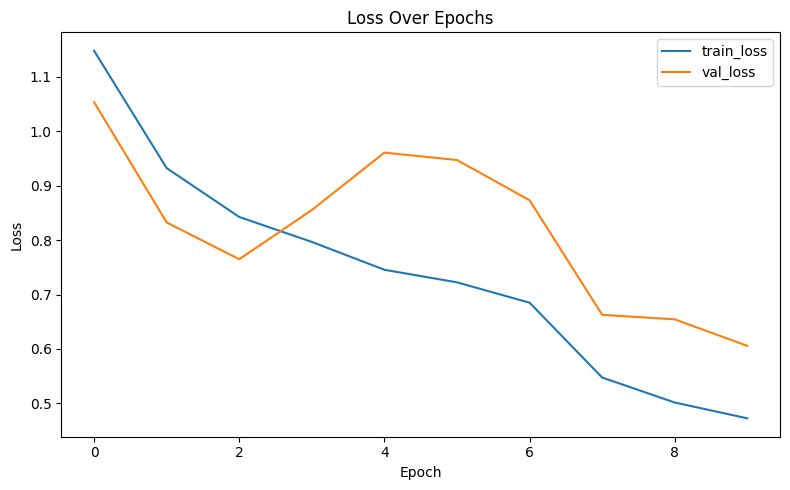

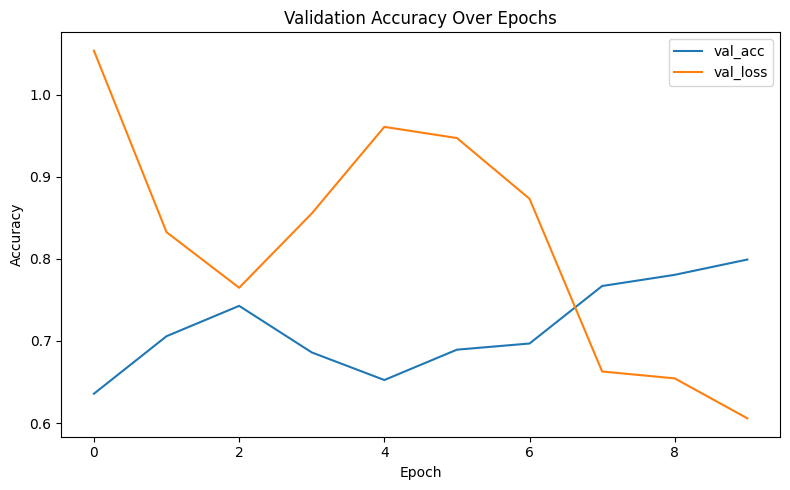

In [ ]:
# ========== PLOT TRAINING METRICS ==========
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'],   label='val_loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['val_loss'], label='val_loss')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.tight_layout(); plt.show()


Classification Report:
               precision    recall  f1-score   support

         CBB     0.5160    0.6789    0.5864       190
        CBSD     0.7464    0.7096    0.7275       365
         CGM     0.5142    0.8005    0.6262       406
         CMD     0.9585    0.8701    0.9121      2201
     Healthy     0.6667    0.5668    0.6127       434

    accuracy                         0.7992      3596
   macro avg     0.6804    0.7252    0.6930      3596
weighted avg     0.8282    0.7992    0.8078      3596



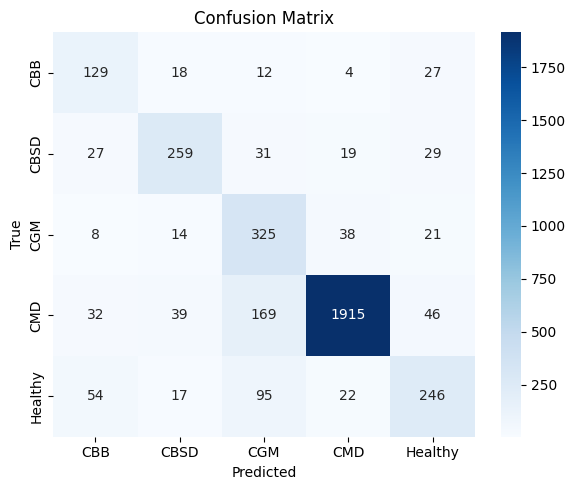

In [ ]:
# ========== EVALUATION & METRICS ==========
# Ensure the saved model path is correct
model.load_state_dict(torch.load("best_resnet50_pytorch.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    # Use the filtered validation loader
    for X, y in val_loader:
        X = X.to(device)
        out = model(X)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        # y is already a tensor, no need for .numpy() here
        all_labels.extend(y.cpu().numpy()) # Use .cpu().numpy() to be consistent

label_map = {0:"CBB",1:"CBSD",2:"CGM",3:"CMD",4:"Healthy"}

print("\nClassification Report:\n",
      classification_report(all_labels, all_preds,
                            target_names=list(label_map.values()), digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()


Classification Report:
               precision    recall  f1-score   support

         CBB     0.5160    0.6789    0.5864       190
        CBSD     0.7464    0.7096    0.7275       365
         CGM     0.5142    0.8005    0.6262       406
         CMD     0.9585    0.8701    0.9121      2201
     Healthy     0.6667    0.5668    0.6127       434

    accuracy                         0.7992      3596
   macro avg     0.6804    0.7252    0.6930      3596
weighted avg     0.8282    0.7992    0.8078      3596



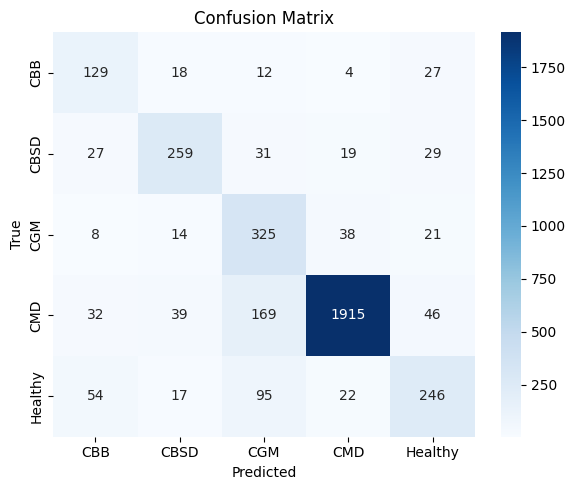

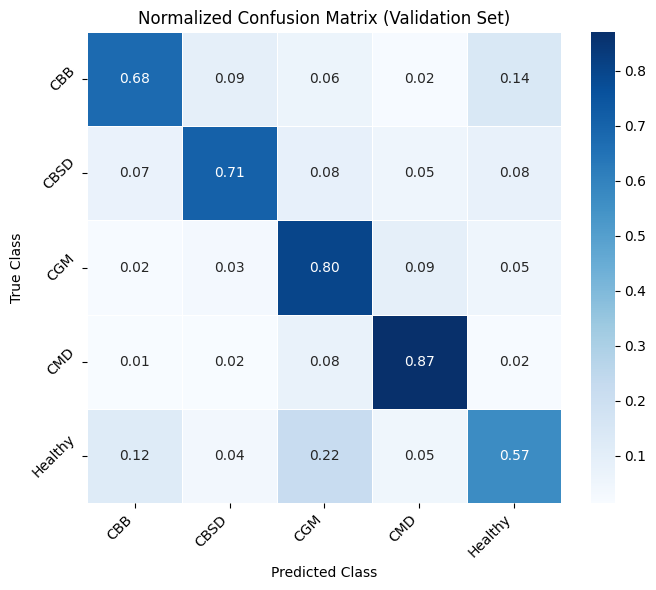

In [ ]:
# ========== EVALUATION & METRICS ==========
# Ensure the saved model path is correct
model.load_state_dict(torch.load("best_resnet50_pytorch.pth"))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    # Use the filtered validation loader
    for X, y in val_loader:
        X = X.to(device)
        out = model(X)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        # y is already a tensor, no need for .numpy() here
        all_labels.extend(y.cpu().numpy()) # Use .cpu().numpy() to be consistent

label_map = {0:"CBB",1:"CBSD",2:"CGM",3:"CMD",4:"Healthy"}

print("\nClassification Report:\n",
      classification_report(all_labels, all_preds,
                            target_names=list(label_map.values()), digits=4))

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the non-normalized confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(label_map.values()),
            yticklabels=list(label_map.values()))
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()

# Normalize the confusion matrix
# Divide each row by the sum of the row to get percentages within each true class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f", # Use .2f for floating point numbers with 2 decimal places
    cmap="Blues",
    xticklabels=list(label_map.values()), # Use labels from the label_map
    yticklabels=list(label_map.values()), # Use labels from the label_map
    linewidths=0.5
)
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.title("Normalized Confusion Matrix (Validation Set)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-52-353341283>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Validation Accuracy', data=accuracy_df, palette='viridis')


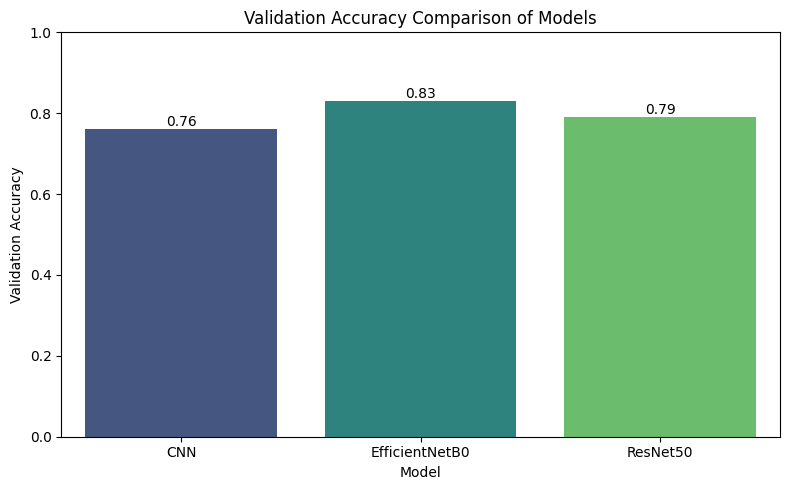

            Model  Validation Accuracy
0             CNN                 0.76
1  EfficientNetB0                 0.83
2        ResNet50                 0.79


In [ ]:
#Comparison

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extract Validation Accuracies
# Replace these values with the final validation accuracies you observed
# from the output of your training runs.
cnn_accuracy = 0.76  # Example value, replace with your CNN result
efficientnet_accuracy = 0.83 # Example value, replace with your EfficientNet result
resnet50_accuracy = 0.79 # Example value, replace with your ResNet50 result


# 2. Create a Pandas DataFrame
data = {'Model': ['CNN', 'EfficientNetB0', 'ResNet50'],
        'Validation Accuracy': [cnn_accuracy, efficientnet_accuracy, resnet50_accuracy]}
accuracy_df = pd.DataFrame(data)

# 3. Plot the Bar Graph
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Model', y='Validation Accuracy', data=accuracy_df, palette='viridis')
plt.title('Validation Accuracy Comparison of Models')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for better comparison

# Add the accuracy values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# You can also print the DataFrame for a quick look at the values
print(accuracy_df)